In [69]:
import jax.numpy as jnp
import numpy as onp
import jax
import jax.random as random
import matplotlib.pyplot as plt

In [70]:
beta_1 = 20
beta_0 = 0.1

def get_manifold(N_samples):
    alphas = jnp.linspace(0, 2*jnp.pi*(1 - 1/N_samples), N_samples)
    rs = jnp.ones(N_samples)
    return jnp.stack([rs, alphas], axis=1)

def eucl_to_polar(x):
    return jnp.stack([x[:, 0] * jnp.cos(x[:, 1]), x[:, 0] * jnp.sin(x[:, 1])], axis=1)

def get_score(N_samples):
    samples = eucl_to_polar(get_manifold(N_samples))
    
    def log_marginal(x, t):
        log_mean_coeff = -0.25 * t ** 2 * (beta_1 - beta_0) - 0.5 * t * beta_0
        mean_coeff = jnp.exp(log_mean_coeff)
        var = 1 - jnp.exp(2. * log_mean_coeff)
        distances = jnp.sum(((x - mean_coeff * samples)**2).reshape(N_samples, -1), axis=1)
        return jax.scipy.special.logsumexp(-distances/(2*var), b=1/N_samples)

    score = jax.grad(log_marginal)
    return log_marginal, score

In [78]:
def get_distance_to_mf_fun(N_samples):
    mf = eucl_to_polar(get_manifold(N_samples))
    def distance(x):
        distances = jnp.sum(((x - mf)**2).reshape(N_samples, -1), axis=1)
        return jnp.sqrt(jnp.min(distances))
    return distance

N_train = 16
N_mf = 512

def dist_mf_fun(x):
    r = jnp.sqrt(jnp.sum(x**2))
    return jnp.abs(r - 1)

dist_train_fun = get_distance_to_mf_fun(N_train)

_, score_mf = get_score(N_mf)
_, score_train = get_score(N_train)
#mf = eucl_to_polar(get_manifold(N_samples))

data_train = eucl_to_polar(get_manifold(N_train))
data_mf = eucl_to_polar(get_manifold(N_mf))

In [72]:
from jax.experimental.host_callback import id_print
eps = 1e-3
N = 1000
T = 1
timesteps = jnp.linspace(T, eps, N)
dt = timesteps[0] - timesteps[1]

N_samples = 20

shape = (2,)

def reverse_SDE(score_fn, rngs):
    def one_sample(rng):
        def loop_body(i, val):
            rng, x, x_mean, d_train, d_mf = val
            t = timesteps[i]
            beta_t = beta_0 + t * (beta_1 - beta_0)
            diffusion = jnp.sqrt(beta_t)

            drift = -0.5 * beta_t * x

            score = score_fn(x, t)
            drift = drift - diffusion**2 *  score
            rng, step_rng = random.split(rng)
            z = random.normal(step_rng, x.shape)
            x_mean = x - drift * dt
            x = x_mean + diffusion * jnp.sqrt(dt) * z

            d_mf = d_mf.at[i].set(dist_mf_fun(x_mean))
            d_train = d_train.at[i].set(dist_train_fun(x_mean))
            return rng, x, x_mean, d_train, d_mf

        rng, step_rng = random.split(rng)
        x = random.normal(rng, (2,))
        
        d_train = jnp.zeros(N)
        d_mf = jnp.zeros(N)
        
        _, x, x_mean, d_train, d_mf = jax.lax.fori_loop(0, N, loop_body, (rng, x, x, d_train, d_mf))
        return x_mean, d_train, d_mf
    
    return jax.jit(jax.vmap(one_sample))(rngs)

In [73]:
random_seed = 25 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
N_reverse_samples = 5000
rngs = jax.random.split(rng, N_reverse_samples)
sample, d_train, d_mf = reverse_SDE(score_mf, rngs)

In [7]:
mean_dist_train = jnp.mean(d_train, axis=0)
mean_dist_mf = jnp.mean(d_mf, axis=0)

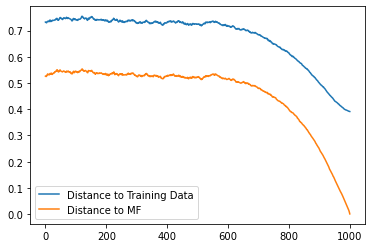

In [8]:
plt.plot(mean_dist_train, label="Distance to Training Data")
plt.plot(mean_dist_mf, label="Distance to MF")
plt.legend()

In [9]:
from flax import linen as nn           # The Linen API
from flax import optim

/home/jakiw/Programs/miniconda3/envs/score_sde/lib/python3.8/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


In [42]:
nn.leaky_relu

<function jax._src.nn.functions.leaky_relu(x, negative_slope=0.01)>

In [192]:
class MLP(nn.Module):
  @nn.compact
  def __call__(self, x, t):
    t = jnp.stack([t, jnp.cos(2*jnp.pi*t), jnp.sin(2*jnp.pi*t)], axis=1)
    t = nn.Dense(3)(t)
    t = nn.leaky_relu(t)
    t = nn.Dense(3)(t)
    t = nn.leaky_relu(t)

    x = nn.Dense(2)(x)                # inline submodules
    x = nn.leaky_relu(x)
    x = nn.Dense(4)(x)                # inline submodules
    x = nn.leaky_relu(x)
    x = nn.Dense(4)(x)                # inline submodules
    x = nn.leaky_relu(x)
    
    x = jnp.hstack([x, t])
    x = nn.Dense(6)(x)                # inline submodules
    x = nn.leaky_relu(x)
    x = nn.Dense(6)(x)                # inline submodules
    x = nn.leaky_relu(x)
    x = nn.Dense(2)(x)
    return x

score_approx = MLP()                    # create model

x = jnp.ones((16, 2))*3                 # get some data
t = jnp.ones((16, ))*5
variables = score_approx.init(rng, x, t) # initialize weights
y = score_approx.apply(variables, x, t)          # make forward pass

In [193]:
def matrix_rowwise(M, v):
    def mul(a, b):
        return a * b
    
    return jax.vmap(mul, (0, 0), 0)(M, v)

In [200]:
def _loss_fn(variables, rng, batch):
    rng, step_rng = random.split(rng)
    ts = random.uniform(rng, (batch.shape[0],), minval=eps, maxval=T)

    log_mean_coeff = -0.25 * ts ** 2 * (beta_1 - beta_0) - 0.5 * ts * beta_0
    mean_coeff = jnp.exp(log_mean_coeff)
    var = 1 - jnp.exp(2. * log_mean_coeff)
    std = jnp.sqrt(var)

    z = random.normal(rng, batch.shape)
    samples = matrix_rowwise(batch, mean_coeff) + matrix_rowwise(z, std) 

    predicted_score = score_approx.apply(variables, samples, ts)
    return jnp.mean((predicted_score  - matrix_rowwise(z, 1/std))**2)

loss_fn = jax.jit(_loss_fn)

def _train_step(optimizer, rng, batch):
    grad_fn = jax.value_and_grad(loss_fn)
    _, grad = grad_fn(optimizer.target, rng, batch)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

train_step = jax.jit(_train_step)

In [203]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)

optimizer = optim.Adam(learning_rate=0.0001).create(variables)
optimizer = jax.device_put(optimizer)

N_optim_steps = 100000

N_train = 10
N_test = 2

rng, step_rng = random.split(rng)
shuffled_data = random.shuffle(step_rng, data_train)
train_data = shuffled_data[:N_train, :]
test_data = shuffled_data[N_train+1:, :]

for epoch in range(N_optim_steps):
    batch = train_data
    rng, step_rng = random.split(rng)
    optimizer = train_step(optimizer, step_rng, batch)
    if epoch % 1000 == 0:
        rng, step_rng = random.split(rng)
        train_eval = jnp.repeat(train_data, 200, axis=0)
        train_loss = loss_fn(optimizer.target, step_rng, train_eval)
        rng, step_rng = random.split(rng)
        test_eval = jnp.repeat(test_data, 500, axis=0)
        eval_loss = loss_fn(optimizer.target, step_rng, test_eval)
        print("Epoch %d, Train: %.2f, \t Test: %.2f" % (epoch, train_loss, eval_loss))

Epoch 0, Train: 15.71, 	 Test: 21.82
Epoch 1000, Train: 17.76, 	 Test: 21.00
Epoch 2000, Train: 19.25, 	 Test: 16.41
Epoch 3000, Train: 35.80, 	 Test: 27.11
Epoch 4000, Train: 25.95, 	 Test: 26.40
Epoch 5000, Train: 20.43, 	 Test: 36.12
Epoch 6000, Train: 23.86, 	 Test: 15.17
Epoch 7000, Train: 26.74, 	 Test: 12.54
Epoch 8000, Train: 15.36, 	 Test: 18.56
Epoch 9000, Train: 28.37, 	 Test: 47.91
Epoch 10000, Train: 18.32, 	 Test: 15.39
Epoch 11000, Train: 15.92, 	 Test: 42.23
Epoch 12000, Train: 46.03, 	 Test: 21.12
Epoch 13000, Train: 24.18, 	 Test: 38.28
Epoch 14000, Train: 15.15, 	 Test: 22.21
Epoch 15000, Train: 30.37, 	 Test: 19.04
Epoch 16000, Train: 21.74, 	 Test: 25.65
Epoch 17000, Train: 33.40, 	 Test: 26.05
Epoch 18000, Train: 20.30, 	 Test: 18.88
Epoch 19000, Train: 38.56, 	 Test: 25.57
Epoch 20000, Train: 21.00, 	 Test: 16.71
Epoch 21000, Train: 15.33, 	 Test: 21.07
Epoch 22000, Train: 21.10, 	 Test: 26.57
Epoch 23000, Train: 15.90, 	 Test: 18.66
Epoch 24000, Train: 25.76, 	 

In [140]:
x = jnp.array([[1.0, 1.0]])
t = jnp.array([1.0])
score_approx_single = lambda x, t: score_approx.apply(variables, x[jnp.newaxis, :], jnp.array([t]))[0]

In [141]:
score_approx_single(jnp.ones(2), 1.0)

DeviceArray([0.00731047, 0.00144315], dtype=float32)

In [204]:
def quiver_plot(sc_fn, t):
    base_grid = jnp.linspace(-1.5, 1.5, 16)
    x_grid, y_grid = jnp.meshgrid(base_grid, base_grid)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    coords = jnp.stack([x_grid, y_grid], axis=1)
    ts = jnp.ones(coords.shape[0]) * t
    scores = jax.jit(jax.vmap(sc_fn, (0, 0), 0))(coords, ts)
    plt.quiver(coords[:, 0], coords[:, 1], scores[:, 0], scores[:, 1])

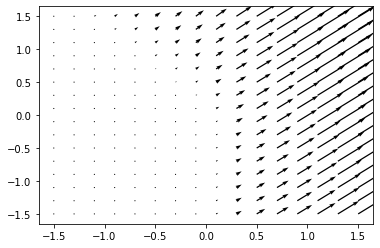

In [205]:
quiver_plot(score_approx_single, 1.0)

In [134]:
sc_approx_fn(jnp.array([[-1, -1]]), jnp.array([1.0]))

TypeError: Cannot concatenate arrays with different ranks, got 1, 2.